## Data Extraction

In [32]:
import numpy as np
import pandas as pd
import datetime

In [33]:
df = pd.read_csv('file_name.csv')  

In [34]:
df

,Value,Date
0,13.706000,20191202
1,14.267895,20191202
2,14.283784,20191202
3,14.054737,20191202
4,14.075263,20191202
...,...,...
3916,14.091667,20191126
3917,14.074595,20191126
3918,14.008108,20191126
3919,13.968333,20191126


## Data Preparation

In [35]:
df = df.sort_values(by='Date', ascending=True)
df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

In [36]:
df.index = df.Date
df['Value'] = df.resample('D')['Value'].min()
df = df.drop_duplicates()
df = df.asfreq('D')
df = df.ffill(axis = 0)

## Data Visualisation

In [37]:
import plotly.graph_objects as go

In [38]:
trace1 = go.Scatter(
    x = df.index,
    y = df.Value,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = 'Signal Value Plot',
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1], layout=layout)
fig.show()

In [39]:
import torch
import os
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 36, 18
register_matplotlib_converters()

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data Exploration

In [40]:
df = df.drop(['Date'], axis = 1)

In [41]:
# df = df.reset_index()

In [42]:
test_data_size = 20

train_data = df[:-test_data_size].values

test_data = df[-test_data_size:].values

In [43]:
test_data.shape

(20, 1)

In [44]:
train_data.shape

(55, 1)

In [45]:
scaler = MinMaxScaler()

scaler = scaler.fit(train_data)

train_data = scaler.transform(train_data)

test_data = scaler.transform(test_data)

In [46]:
test_data

array([[0.9747878 ],
       [0.91621245],
       [0.94918781],
       [0.9796955 ],
       [0.98100547],
       [0.98100547],
       [0.98100547],
       [0.98100547],
       [0.96148695],
       [0.9584068 ],
       [0.95081761],
       [0.96279692],
       [0.93668842],
       [0.95783283],
       [0.95783283],
       [0.93768001],
       [0.92651518],
       [0.91273829],
       [0.89169842],
       [0.94851827]])

In [47]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [48]:
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [49]:
X_train.shape

torch.Size([44, 10, 1])

In [50]:
torch.Size([17, 5, 1])

torch.Size([17, 5, 1])

In [51]:
X_train[:2]

tensor([[[0.9210],
         [0.9594],
         [0.8529],
         [0.0000],
         [0.7987],
         [0.7987],
         [0.7987],
         [0.8972],
         [0.9745],
         [0.8759]],

        [[0.9594],
         [0.8529],
         [0.0000],
         [0.7987],
         [0.7987],
         [0.7987],
         [0.8972],
         [0.9745],
         [0.8759],
         [0.9602]]])

## Build Model

In [52]:
class BatterySignalPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(BatterySignalPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

## Training


In [53]:
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-2)
  num_epochs = 300

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [54]:
model = BatterySignalPredictor(
  n_features=1,
  n_hidden=700,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 35.90650177001953 test loss: 7.2738542556762695
Epoch 10 train loss: 9.714523315429688 test loss: 1.9810478687286377
Epoch 20 train loss: 10.733814239501953 test loss: 2.190664768218994
Epoch 30 train loss: 1.9656963348388672 test loss: 0.36465469002723694
Epoch 40 train loss: 0.8262825608253479 test loss: 0.13532277941703796
Epoch 50 train loss: 0.8972903490066528 test loss: 0.16170966625213623
Epoch 60 train loss: 0.4372897446155548 test loss: 0.057802390307188034
Epoch 70 train loss: 0.26213178038597107 test loss: 0.02798616886138916
Epoch 80 train loss: 0.19020377099514008 test loss: 0.009739713743329048
Epoch 90 train loss: 0.16009870171546936 test loss: 0.005111517384648323
Epoch 100 train loss: 0.1612495481967926 test loss: 0.005437618121504784
Epoch 110 train loss: 0.15965472161769867 test loss: 0.0045208195224404335
Epoch 120 train loss: 0.15900970995426178 test loss: 0.004476738162338734
Epoch 130 train loss: 0.15862932801246643 test loss: 0.00456141959875

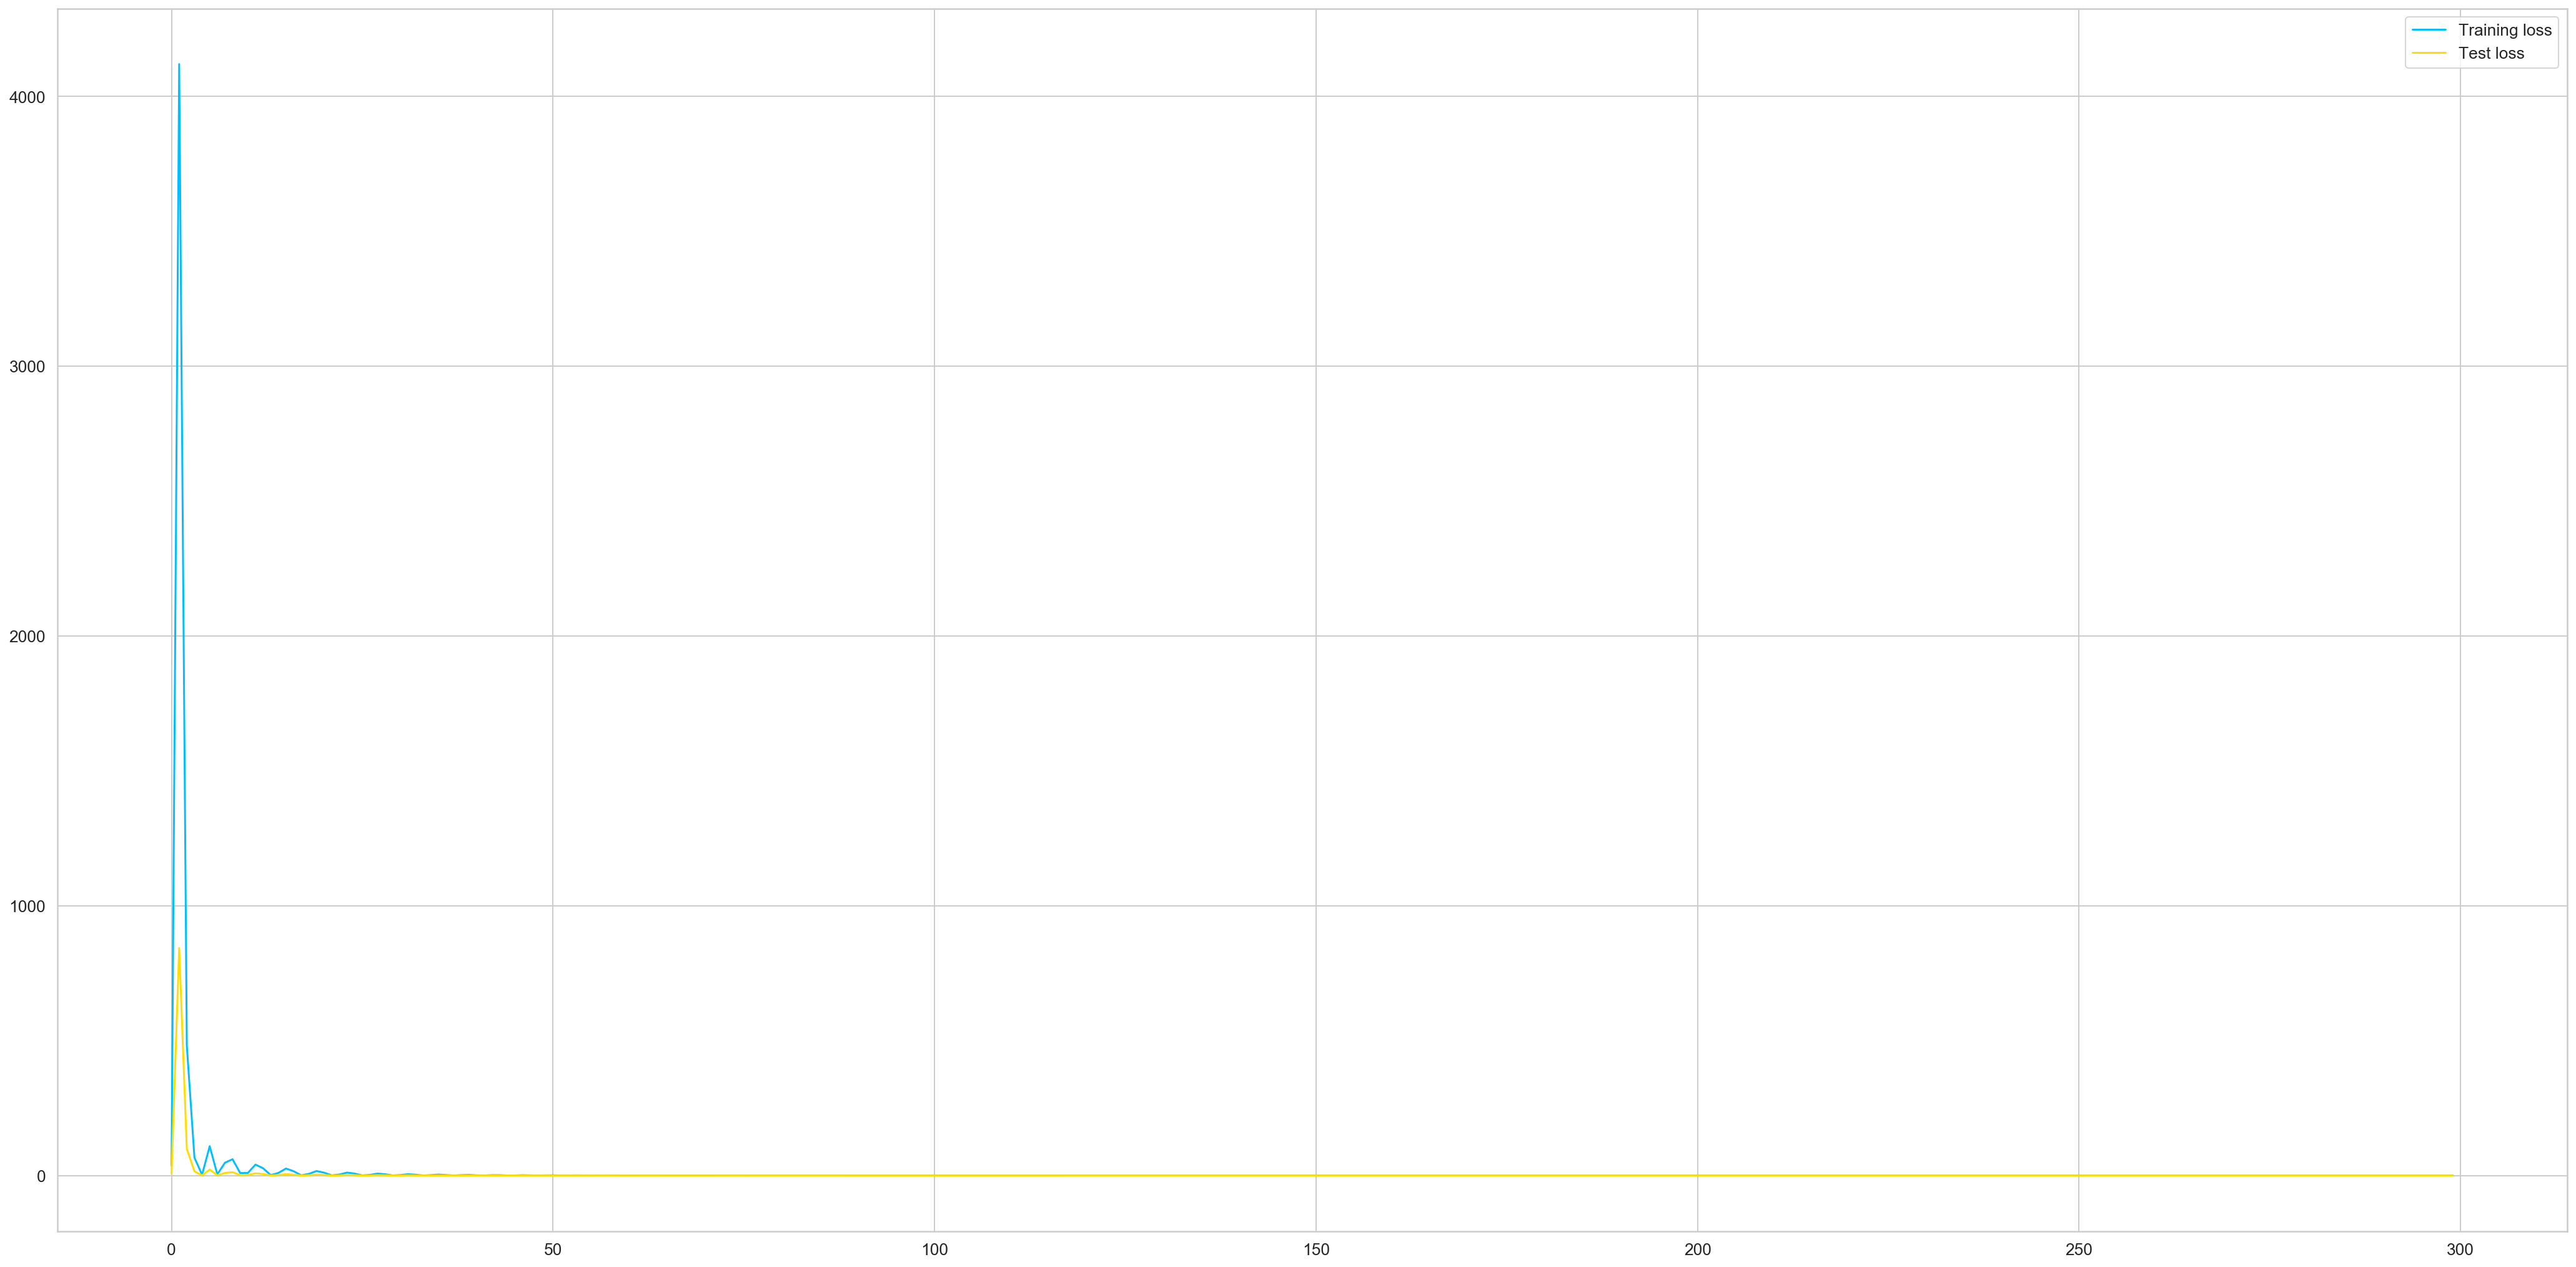

In [55]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
# plt.ylim((0, 5))
plt.legend();

## Predicting daily signal

In [59]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [60]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

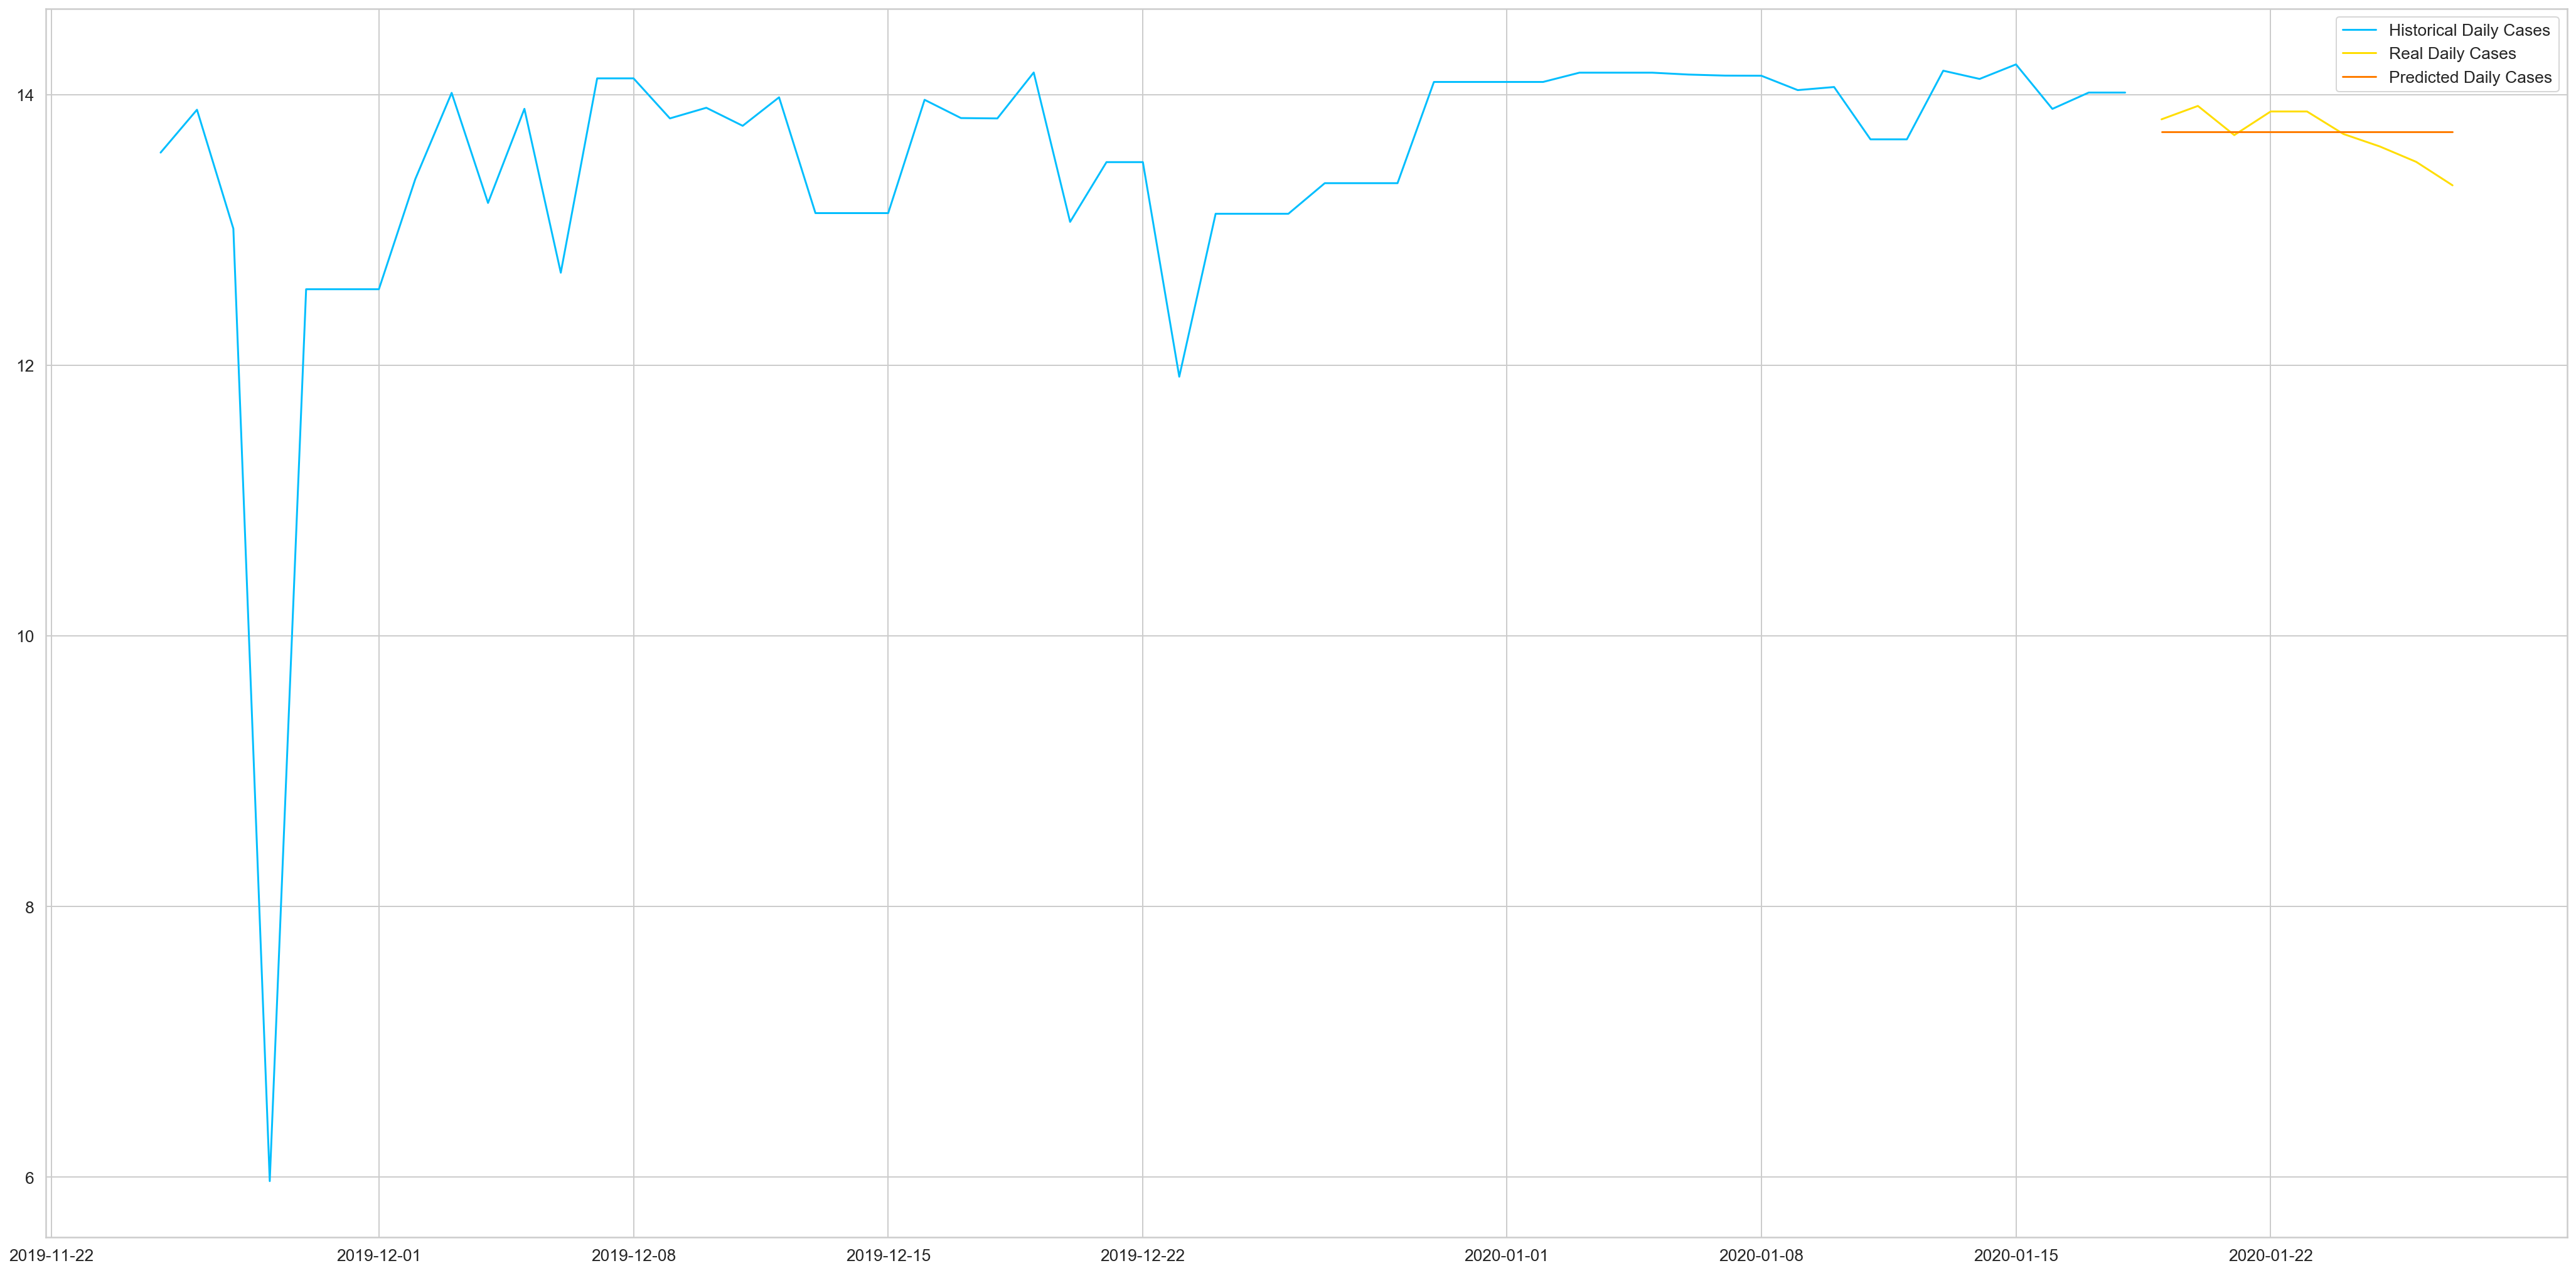

In [61]:
plt.plot(
  df.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  df.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  df.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)

plt.legend();

## Use all data for training

In [62]:
scaler = MinMaxScaler()

scaler = scaler.fit(df)

all_data = scaler.transform(df)

all_data.shape

(75, 1)

In [63]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = BatterySignalPredictor(
  n_features=1,
  n_hidden=300,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 40.493492126464844
Epoch 10 train loss: 0.48329055309295654
Epoch 20 train loss: 0.5920745134353638
Epoch 30 train loss: 0.3387889862060547
Epoch 40 train loss: 0.22729872167110443
Epoch 50 train loss: 0.18367892503738403
Epoch 60 train loss: 0.1662147492170334
Epoch 70 train loss: 0.15937286615371704
Epoch 80 train loss: 0.15881748497486115
Epoch 90 train loss: 0.15905793011188507
Epoch 100 train loss: 0.15862441062927246
Epoch 110 train loss: 0.15867453813552856
Epoch 120 train loss: 0.15861931443214417
Epoch 130 train loss: 0.15862464904785156
Epoch 140 train loss: 0.15862123668193817
Epoch 150 train loss: 0.15861916542053223
Epoch 160 train loss: 0.15861919522285461
Epoch 170 train loss: 0.1586192399263382
Epoch 180 train loss: 0.15861919522285461
Epoch 190 train loss: 0.15861912071704865
Epoch 200 train loss: 0.15861915051937103
Epoch 210 train loss: 0.15861913561820984
Epoch 220 train loss: 0.15861915051937103
Epoch 230 train loss: 0.15861907601356506
Epoch 24

In [64]:
DAYS_TO_PREDICT = 7

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [65]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [66]:
df.index[-1]

Timestamp('2020-02-07 00:00:00', freq='D')

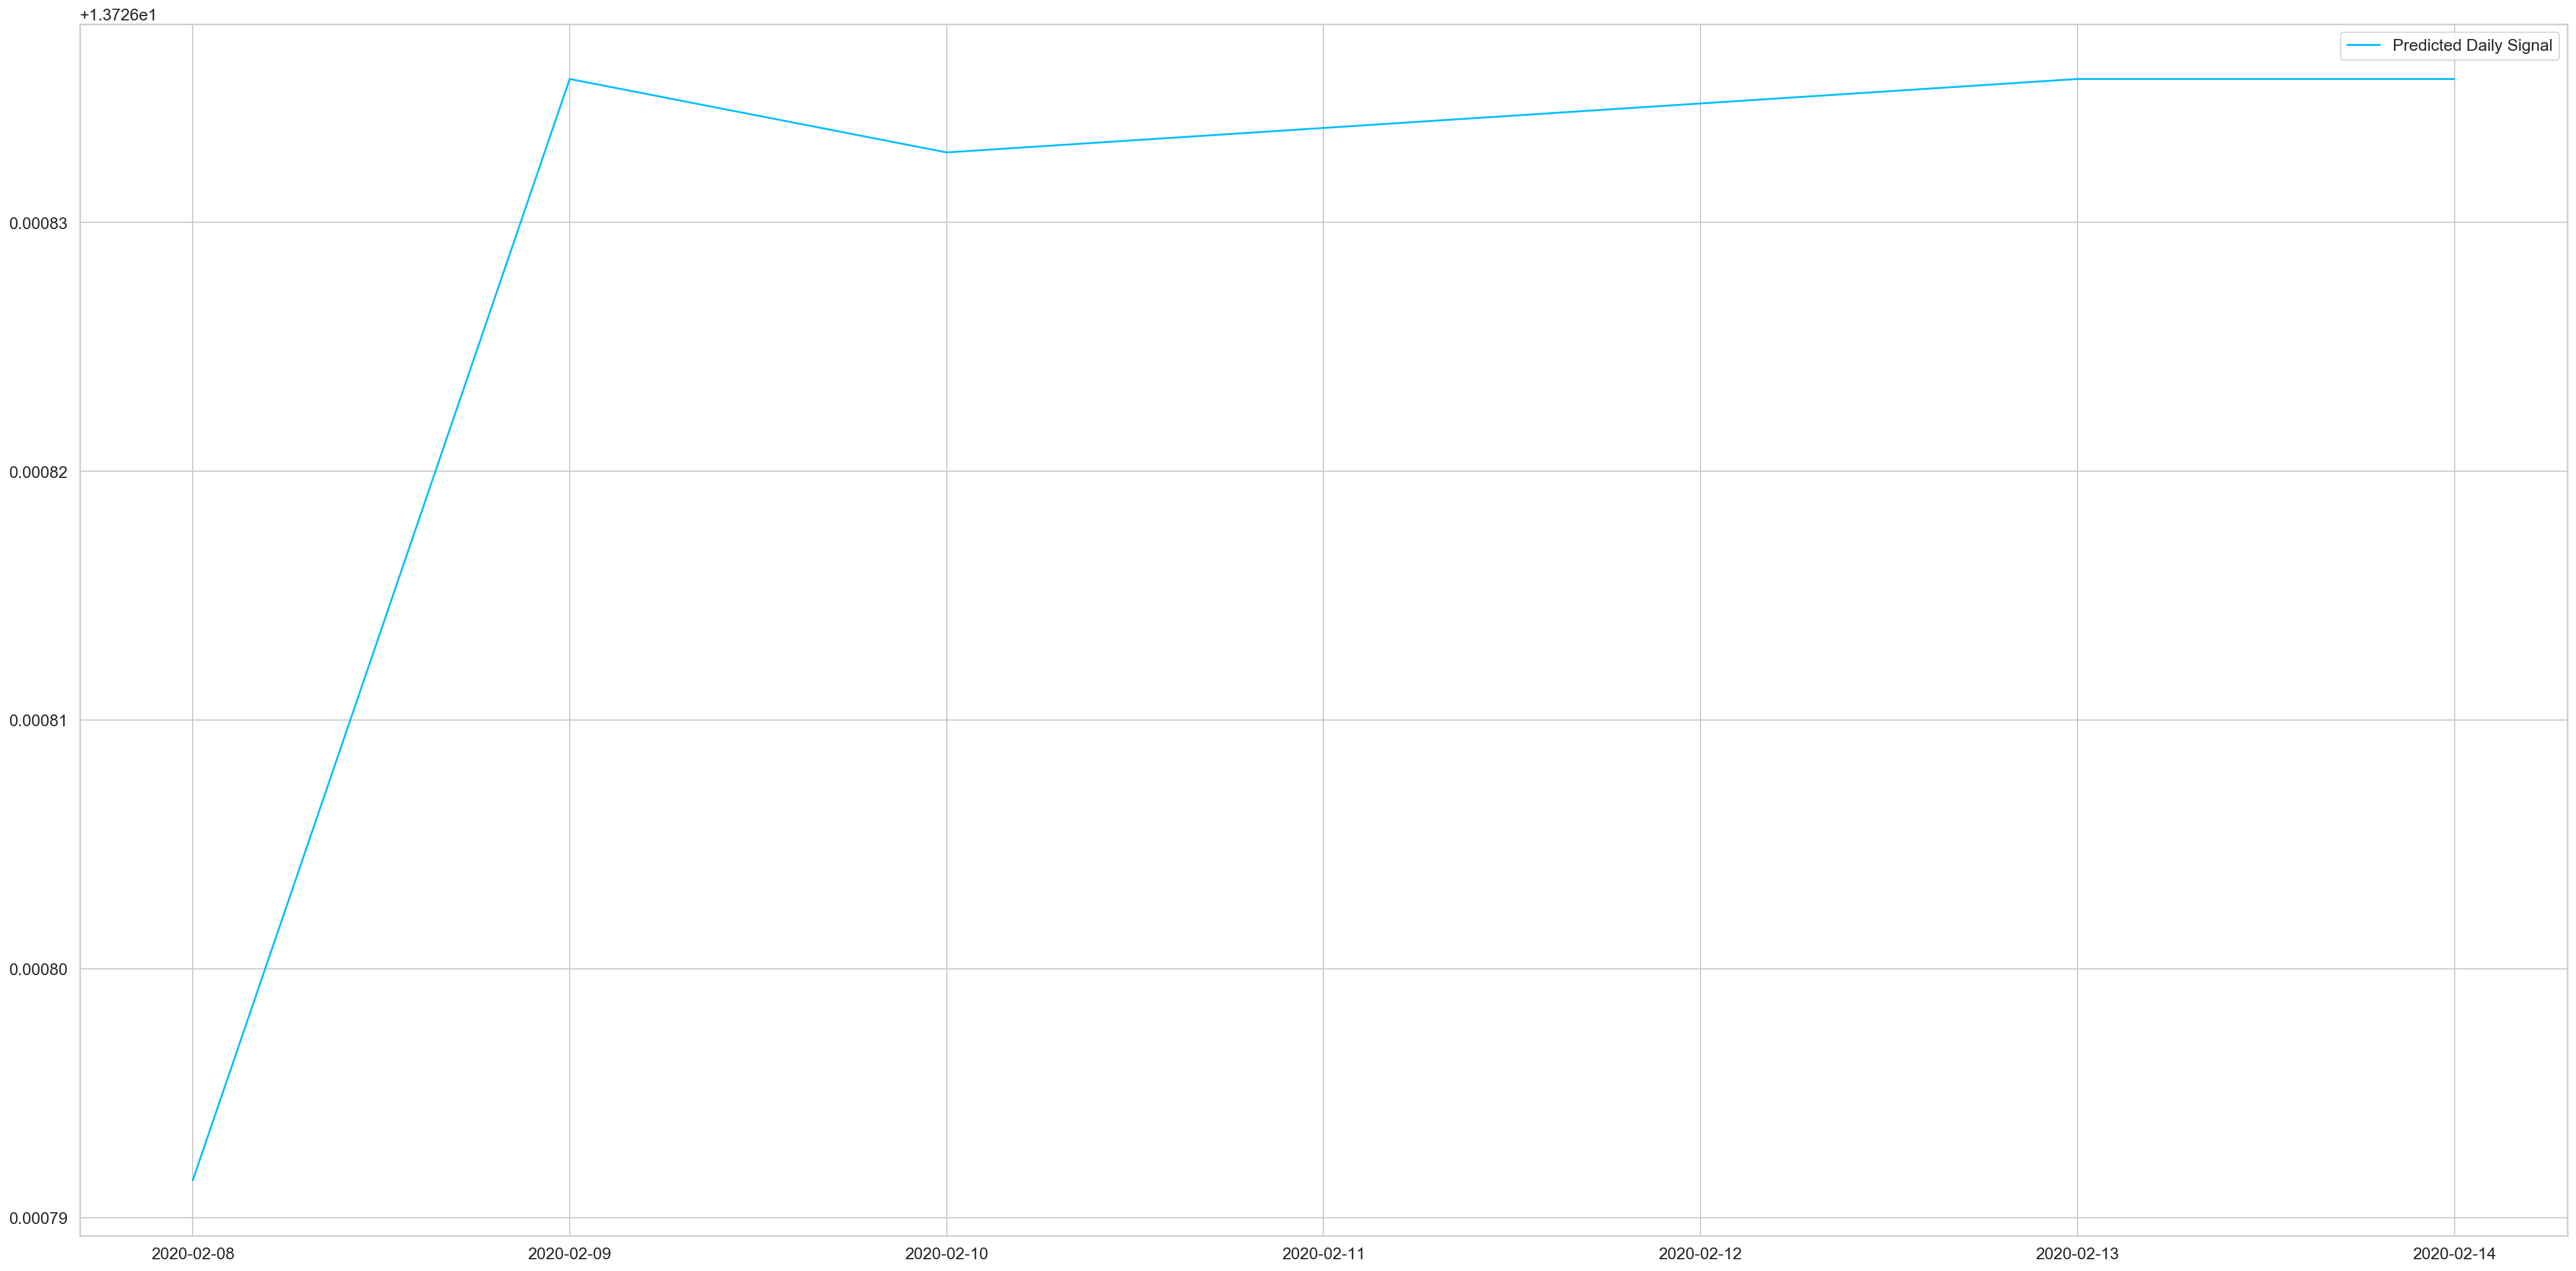

In [67]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Signal')
plt.legend();

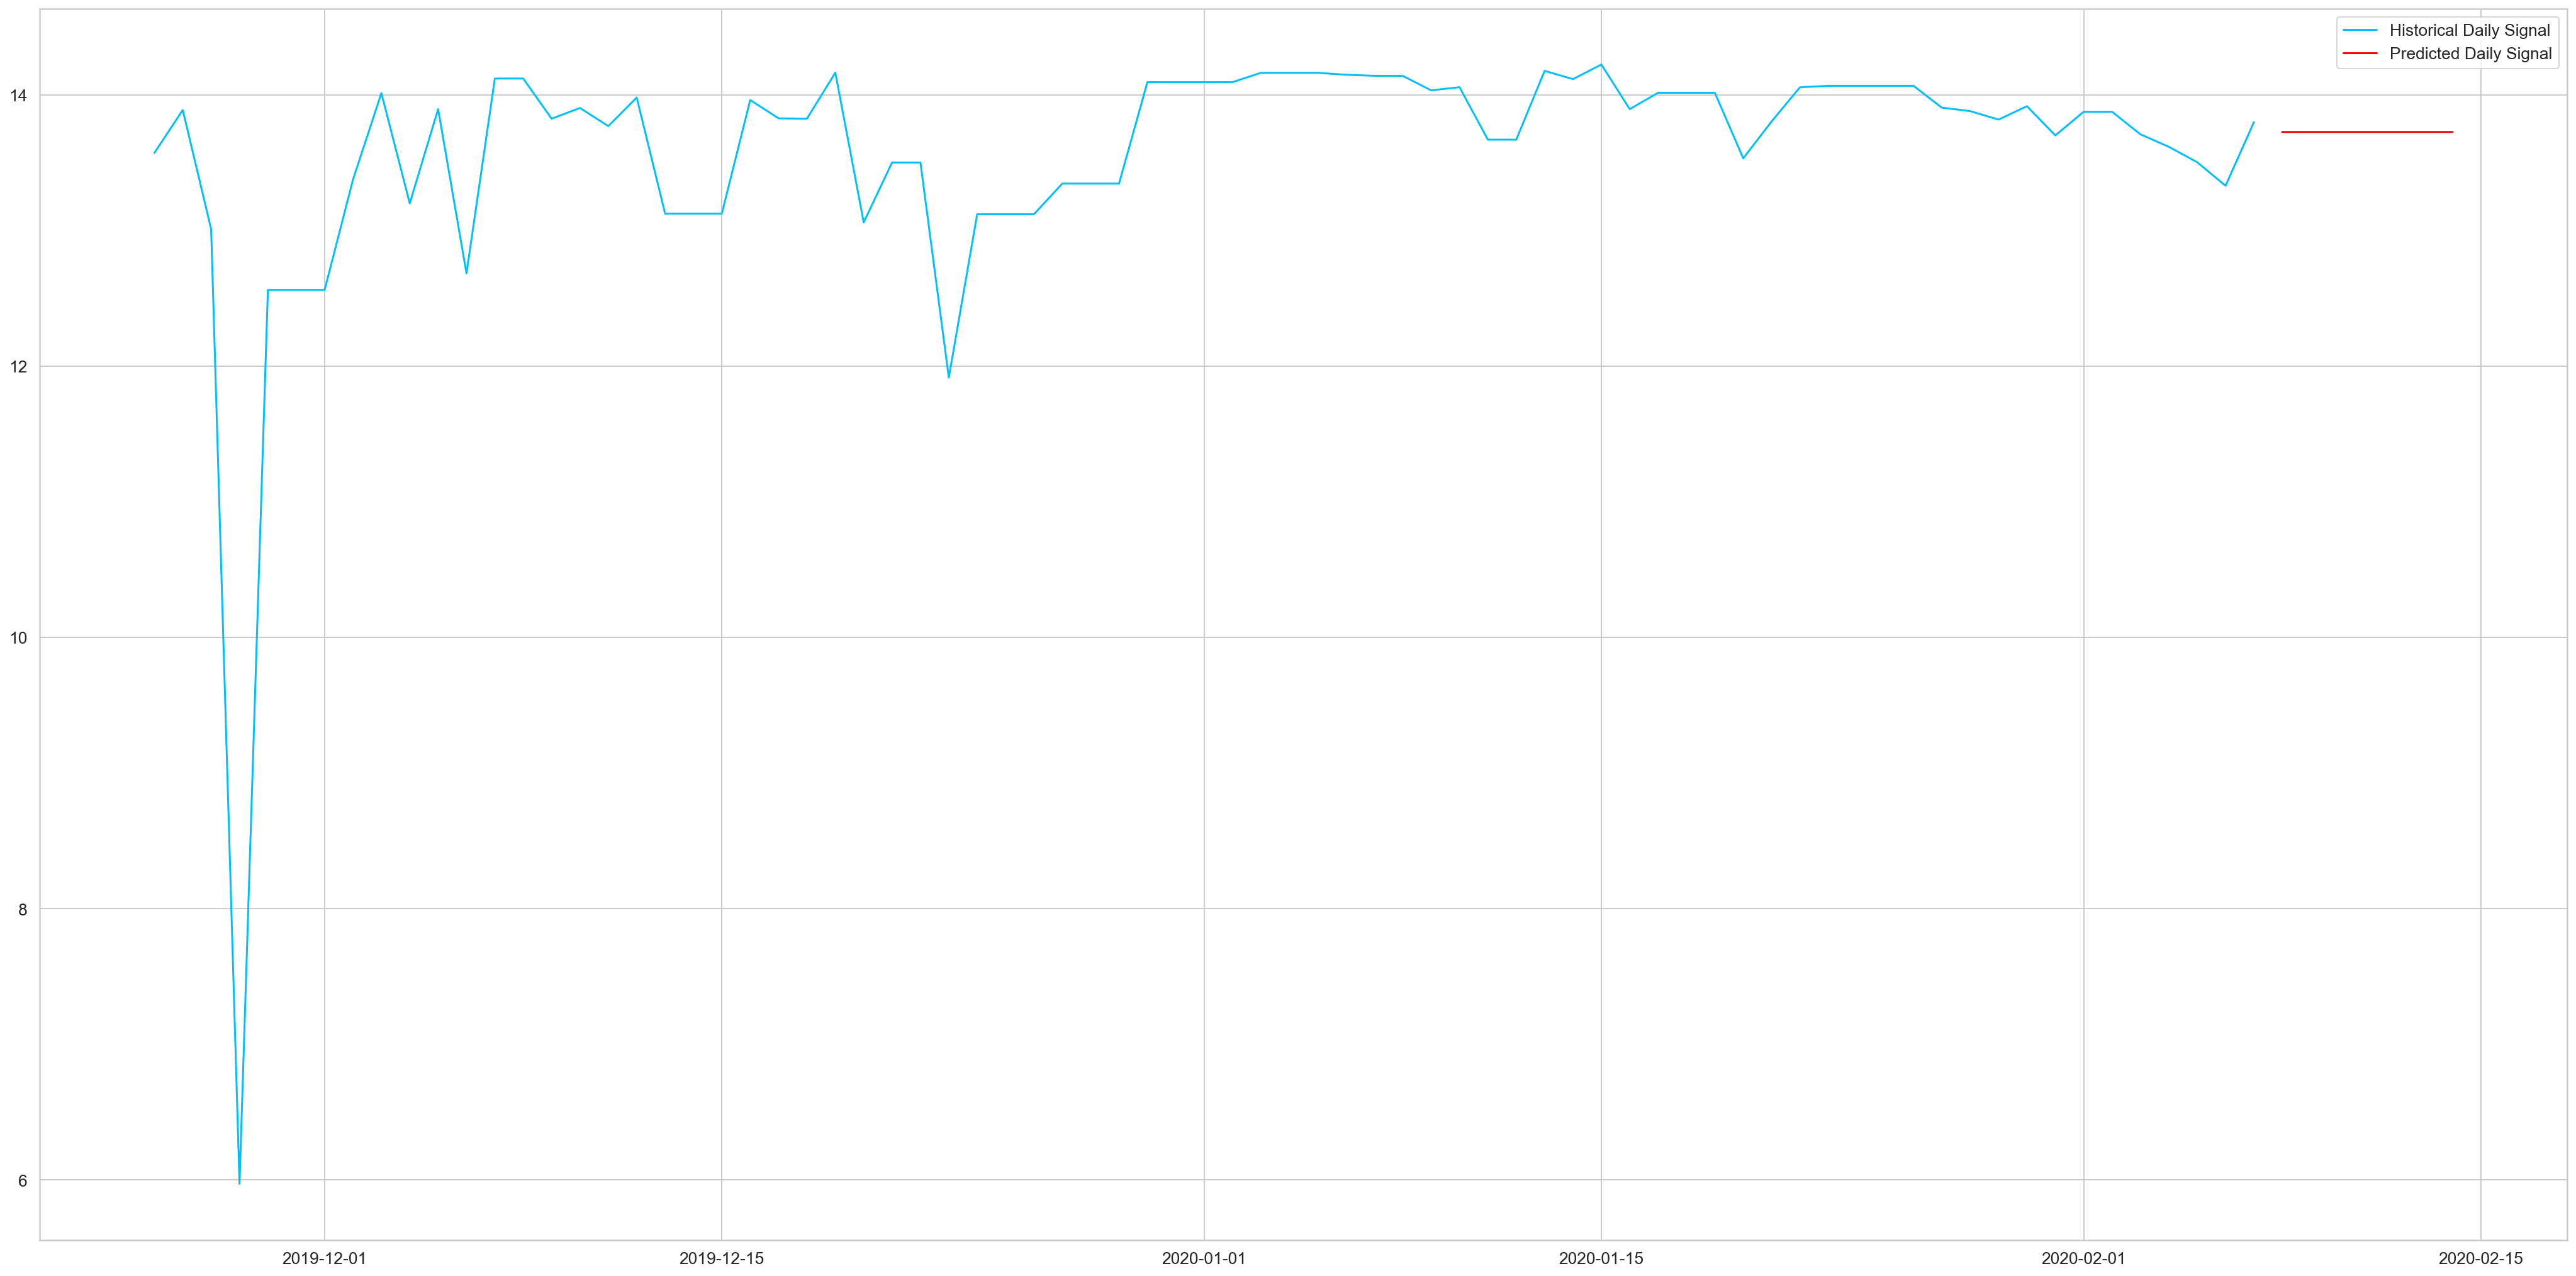

In [68]:
plt.plot(df, label='Historical Daily Signal')
plt.plot(predicted_cases, label='Predicted Daily Signal', color = 'red')
plt.legend();

In [69]:
predicted_cases

2020-02-08    13.726791
2020-02-09    13.726836
2020-02-10    13.726833
2020-02-11    13.726834
2020-02-12    13.726835
2020-02-13    13.726836
2020-02-14    13.726836
Freq: D, dtype: float64